In [2]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages, MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.constants import Send

from typing import TypedDict
from typing import List
from typing import Annotated
from dotenv import load_dotenv

import os
import operator

from pydantic import BaseModel
from pydantic import Field

load_dotenv()


/Users/abdulvajid/AI/PROJECTS/Simple-Multi-turn-ChatBot-with-langgraph/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


True

In [3]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
)

In [4]:
msg = [
       SystemMessage(content='You are a helpfull Ai assistent'),
       HumanMessage(content="hai , could you help me?"),
       ]

model.invoke(msg)

AIMessage(content="Hi there! Yes, I'd love to help. What do you need assistance with? Just let me know what's on your mind.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--1fae8b15-7d67-4321-b658-2c529b41c59b-0', usage_metadata={'input_tokens': 15, 'output_tokens': 31, 'total_tokens': 46, 'input_token_details': {'cache_read': 0}})

In [ ]:
# Structured Output Schema for the Analyst 
class Profile(BaseModel):
    name:str = Field(description='name of the analyst')
    expertise:str = Field(description='the field where the analyst specialized in')
    job:str = Field(description='job of the analyst')  

In [5]:
class Analysts(BaseModel):
    analysts: list[Profile]

In [ ]:
# Overall general State
class OverallState(MessagesState):
    max_analyst: int
    analysts: list[Analysts]
    context: Annotated[list, add_messages]

In [ ]:
# System prmpt for first node
system_prompt = """You are an intelligent AI assistant specialized in generating different expertise detailed analyst profiles based on a specific topic specified by user.
Generate {max_analyst} anlyste profiles.
    """

# Node_1
def create_analysts(state: OverallState) -> OverallState:
    system_prompt = system_prompt.format(max_analyst=state['max_analyst'])
    system_prompt = [
        SystemMessage(content=system_prompt)
        ]
    sturctured_output_model = model.with_structured_output(Analysts)
    messages = system_prompt + state['messages'] # list concat
    analysts = sturctured_output_model.invoke(messages)
    return {'analysts': analysts}

In [8]:
graph = StateGraph(OverallState)

# Nodes
graph.add_node(create_analysts,'create_analysts')

# Edges
graph.add_edge(START, 'create_analysts')
graph = graph.compile()


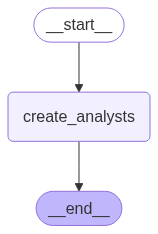

In [9]:
graph

In [10]:
graph.invoke({'messages':[HumanMessage(content='ai in education')], 'max_analyst':5})

{'messages': [HumanMessage(content='ai in education', additional_kwargs={}, response_metadata={}, id='43fa71f9-7ab5-4a8f-b744-1e914145189c')],
 'max_analyst': 5,
 'analysts': Analysts(analysts=[Profile(name='Dr. Anya Sharma', expertise='AI in personalized learning', job='Educational Data Scientist'), Profile(name='Mr. Ben Carter', expertise='AI-driven assessment and feedback', job='AI Education Consultant'), Profile(name='Ms. Chloe Davis', expertise='AI for curriculum development', job='Curriculum Design Specialist'), Profile(name='Mr. David Lee', expertise='AI in special education', job='Assistive Technology Specialist'), Profile(name='Dr. Emily Green', expertise='AI ethics in education', job='Education Policy Analyst')]),
 'context': []}